In [1]:
import jax.numpy as np
import jax
from jax import jit, grad, vmap, random, lax
import matplotlib.pyplot as plt

In [2]:
RNG_KEY = random.PRNGKey(0)

/usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/jax/lib/xla_bridge.py:118: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
# object ids
OBJ_NONE=0.0
OBJ_FLOOR=0.1
OBJ_CEIL=.2
OBJ_WALL_RD=.3
OBJ_WALL_WH=.4
OBJ_WALL_GR=.5
OBJ_SHORT_BLOCK=.6
OBJ_TALL_BLOCK=.7
OBJ_LIGHT=1.0
OBJ_SPHERE=0.9

In [4]:
def length(p):
  return np.linalg.norm(p)

def normalize(p):
  return p/length(p)

# def sdSphere(p,radius):
#   return length(p) - radius

def udBox(p, b):
  # b = half-widths
  return length(np.maximum(np.abs(p)-b,0.0))

def rotateX(p,a):
  c = np.cos(a); s = np.sin(a);
  px,py,pz=p[0],p[1],p[2]
  return np.array([px,c*py-s*pz,s*py+c*pz])

def rotateY(p,a):
  c = np.cos(a); s = np.sin(a);
  px,py,pz=p[0],p[1],p[2]
  return np.array([c*px+s*pz,py,-s*px+c*pz])

def rotateZ(p,a):
  c = np.cos(a); s = np.sin(a);
  px,py,pz=p[0],p[1],p[2]
  return np.array([c*px-s*py,s*px+c*py,pz])

@jit
def opU(a,b):
  condition = np.tile(a[1,None]<b[1,None], [2])
  return np.where(condition, a, b)

def clamp01(v):
  # maybe we should use sigmoid instead of hard thresholding for nicer gradients / soft shadows?
  return np.minimum(np.maximum(v,0.0),1.0)

def relu(a):
  return np.maximum(a,0.)

def dot(a,b):
  return np.sum(a*b)

In [5]:
def df(obj_id, dist):
  return np.array([obj_id, dist])

@jit
def sdScene(p):
  # p is [3,]
  px,py,pz=p[0],p[1],p[2]
  # floor
  obj_floor = df(OBJ_FLOOR, py) # py = distance from y=0
  res = obj_floor  
  # ceiling
  obj_ceil = df(OBJ_CEIL, 4.-py)
  res = opU(res,obj_ceil)
  # backwall
  obj_bwall = df(OBJ_WALL_WH, 4.-pz)

  res = opU(res,obj_bwall)
  
  # leftwall
  obj_lwall = df(OBJ_WALL_RD, px-(-2))
  res = opU(res,obj_lwall)
  
  # rightwall
  obj_rwall = df(OBJ_WALL_GR, 2-px)
  res = opU(res,obj_rwall)
  
  # light
  obj_light = df(OBJ_LIGHT, udBox(p - np.array([0,3.9,2]), np.array([.5,.01,.5])))
  res = opU(res,obj_light)
  
  # tall block
  bh = 1.3
  p2 = rotateY(p- np.array([-.64,bh,2.6]),.15*np.pi)
  d = udBox(p2, np.array([.6,bh,.6]))
  obj_tall_block = df(OBJ_TALL_BLOCK, d)
  res = opU(res,obj_tall_block)  
  
  # short block
  bw = .6
  p2 = rotateY(p- np.array([.65,bw,1.7]),-.1*np.pi)
  d = udBox(p2, np.array([bw,bw,bw]))
  obj_short_block = df(OBJ_SHORT_BLOCK, d)
  res = opU(res,obj_short_block)
  
  return res

In [6]:
# Discussion of cosine-weighted importance sampling for Lambertian BRDFs,
# http://www.rorydriscoll.com/2009/01/07/better-sampling/
# and implementation here:
# https://www.shadertoy.com/view/4tl3z4
@jit
def sampleCosineWeightedHemisphere(rng_key, n):
  rng_key, subkey = random.split(rng_key)
  u = random.uniform(subkey,shape=(2,),minval=0,maxval=1)
  u1, u2 = u[0], u[1]
  uu = normalize(np.cross(n, np.array([0.,1.,1.])))
  vv = np.cross(uu,n)
  ra = np.sqrt(u2)
  rx = ra*np.cos(2*np.pi*u1)
  ry = ra*np.sin(2*np.pi*u1)
  rz = np.sqrt(1.-u2)
  rr = rx*uu+ry*vv+rz*n
  return normalize(rr)


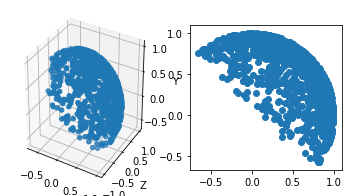

In [7]:
# testing cosine-weighted sphere projection
from mpl_toolkits.mplot3d import Axes3D

nor = normalize(np.array([[1.,1.,0.]]))
nor = np.tile(nor,(1000,1))
rng_key = random.split(RNG_KEY, 1000)
rd = vmap(sampleCosineWeightedHemisphere)(rng_key, nor)

fig = plt.figure()
ax = fig.add_subplot(121, projection='3d')
ax.scatter(rd[:,0],rd[:,2],rd[:,1])
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_zlabel('Y')
ax.set_aspect('equal')

ax = fig.add_subplot(122)
ax.scatter(rd[:,0],rd[:,1])
ax.set_aspect('equal')

In [8]:
fig.savefig('cos_sampling.png', pad_inches=0, bbox_inches='tight')
# %download_file cos_sampling.png

In [9]:
MAX_ITERS=50
HORIZON=20.0

@jit
def raymarch(ro,rd):
  t = 0.0
  for i in range(MAX_ITERS):
    res = sdScene(ro + t*rd)
    t += res[1] # t is scalar.
  obj_id = res[0]
  obj_id = np.where(t>HORIZON, OBJ_NONE, obj_id) 
  return df(obj_id, t)

In [10]:
nor_light = np.array([0.,-1.,0.])
LIGHT_AREA=1.*1.
emissive_const = np.array([25, 25, 25]) # Watts
emittedRadiance = emissive_const / (np.pi * LIGHT_AREA)
lightDiffuseColor = np.array([0.2,0.2,0.2])
leftWallColor = np.array([.611, .0555, .062]) * 1.5
rightWallColor = np.array([.117, .4125, .115]) * 1.5
whiteWallColor = np.array([255, 239, 196]) / 255


BRDF_MAP = [
  (OBJ_NONE, 0.0),
  (OBJ_CEIL, whiteWallColor),
  (OBJ_FLOOR, whiteWallColor),
  (OBJ_LIGHT, lightDiffuseColor),
  (OBJ_SHORT_BLOCK, whiteWallColor),
  (OBJ_TALL_BLOCK, whiteWallColor),
  (OBJ_WALL_GR, rightWallColor),
  (OBJ_WALL_RD, leftWallColor),
  (OBJ_WALL_WH, whiteWallColor),
]

In [11]:
# Calculating Normals with Finite-Differencing
@jit
def calcNormalFiniteDifference(p):
  # derivative approximation via midpoint rule
  eps = 0.001
  dx=np.array([eps,0,0])
  dy=np.array([0,eps,0])
  dz=np.array([0,0,eps])
  # extract just the distance component
  nor = np.array([
    sdScene(p+dx)[1] - sdScene(p-dx)[1],
    sdScene(p+dy)[1] - sdScene(p-dy)[1],
    sdScene(p+dz)[1] - sdScene(p-dz)[1],
  ])
  return normalize(nor)

In [12]:
# Calculating Normals using AutoDiff
@jit
def dist(p):
  # return the distance-component only
  return sdScene(p)[1]

@jit
def calcNormal(p):
  return normalize(grad(dist)(p))

In [36]:
@jit
def trace_direct(rng_key, ro, rd):
  # emission and direct lighting contributions to radiance.
  res = raymarch(ro,rd)
  
  # assign lambertian brdfs to intersections
  condlist, choicelist = [], []
  for obj_idx, obj_color in BRDF_MAP:
    condlist.append(res[0] == obj_idx)
    choicelist.append(obj_color)
  brdf = np.select(condlist, choicelist)

  radiance = np.zeros(3)

  t = res[1]
  eps = 0.0001
  p = ro + (t-eps)*rd
  nor = calcNormal(p)
  did_intersect = res[0] != OBJ_NONE
  rng_key, subkey = random.split(rng_key)

  # Estimate direct area contribution
  # each of the intersect points has some amount of light arriving
  # sample point on area light TODO (ejang) - fix hardcoded light position
  rng_key, subkey = random.split(rng_key)
  p_light_x = random.uniform(subkey, minval=-.5, maxval=.5)
  rng_key, subkey = random.split(rng_key)
  p_light_z = random.uniform(subkey, minval=2. + -.5, maxval=2. + .5)
  p_light = np.array([p_light_x, 3.9, p_light_z])
  
  wi_light = normalize(p_light - p)
  res2 = raymarch(p + 0.001 * nor, wi_light)
  # occlusion factor
  vis = res2[0] == OBJ_LIGHT
  pdf_A = 1./LIGHT_AREA
  square_distance = np.sum(np.square(p_light-p))
  Li_direct = (brdf * 
               relu(dot(nor, wi_light)) * 
               relu(dot(nor_light,-wi_light)) * 
               emittedRadiance) / (square_distance * pdf_A)
  zeros = np.zeros_like(radiance)
  isect_and_vis = np.logical_and(did_intersect, vis)
  radiance += np.where(isect_and_vis, Li_direct, zeros)
  return res, did_intersect, p, nor, brdf, radiance

@jit
def sample_recursive_ray(rng_key, p, nor):
  # To allow JAX to jit this, we don't prune p to get did_intersect items.
  ro2 = p + 0.001 * nor # bump along normal.
  rd2 = sampleCosineWeightedHemisphere(rng_key, nor)
  return ro2, rd2

def trace(rng_key,ro,rd,depth):
  res, did_intersect, p, nor, brdf, radiance = trace_direct(rng_key, ro, rd)
  zeros = np.zeros_like(radiance)

  # emitted radiance. This is only counted if it's an eye ray, since
  # this contribution is also added in at every bounce.
  if depth==0: # is eye ray
    is_light = res[0] == OBJ_LIGHT
    Li_e = emittedRadiance # Lambertian emitter
    radiance += np.where(is_light, Li_e, zeros)

  # indirect incoming contribution for intersected points
  # instead of RR sampling, we just trace for a fixed number of steps
  # to yield a good approximation and allow python to statically unroll.
  if depth < 3: # if depth >= 4, hangs on compile?
    rng_key, subkey = random.split(rng_key)
    ro2, rd2 = sample_recursive_ray(rng_key, p, nor)
    Li_indirect = trace(subkey,ro2,rd2,depth+1)
    # doing cosweighted sampling cancels out the geom term
    radiance += np.where(did_intersect, brdf * Li_indirect, zeros)
  return radiance # actually, radiance

In [37]:
# render the image
# perspective camera with image plane centered at 0,0,0

N=64 # width of image plane
xs=np.linspace(0,1,N) # 10 pixels
us,vs = np.meshgrid(xs,xs) 
uv = np.vstack([us.flatten(),vs.flatten()]).T # 10x10 image grid
# normalize pixel locations to -1,1
p = np.concatenate([-1+2*uv, np.zeros((N*N,1))], axis=1)
# Render a pinhole camera.
eye = np.tile(np.array([0,2.,-3.5]),(p.shape[0],1))
look = np.array([[0,2.0,0]]) # look straight ahead
w = vmap(normalize)(look - eye)
up = np.array([[0,1,0]]) # up axis of world
u = vmap(normalize)(np.cross(w,up))
v = vmap(normalize)(np.cross(u,w))
d=2.2 # focal distance
rd = vmap(normalize)(p[:,0,None]*u + p[:,1,None]*v + d*w)


In [38]:
# # UNCOMMENT TO USE Orthographic projection camera

# N=150 # width of image plane
# xs=np.linspace(0,1,N) # 10 pixels
# us,vs = np.meshgrid(xs,xs) 
# us = (2*us-1)
# vs *= 2
# uv = np.vstack([us.flatten(),vs.flatten()]).T # 10x10 image grid
# eye = np.concatenate([uv, np.zeros((N*N,1))], axis=1)*2
# rd = np.zeros_like(eye) + np.array([[0, 0, 1]])

# Render


In [39]:
# trace = jit(trace, static_argnums=(3,))
render_fn = lambda rng_key, ro, rd : trace(rng_key, ro, rd, 0)
vec_render_fn = vmap(render_fn) # will be very slow if we attempt to jit this.

In [40]:
rng_key = random.split(RNG_KEY, eye.shape[0])

In [41]:
rng_key.shape

(4096, 2)

In [44]:
# %%time
img = vec_render_fn(rng_key, eye, rd)
print('done compiling')

done compiling


W1128 12:54:52.900663 4624233920 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


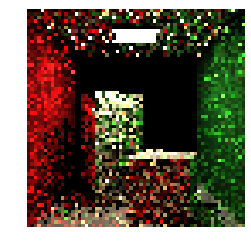

In [45]:
img = np.fliplr(np.flipud(img.reshape((N,N,3))))
plot = plt.imshow(img,interpolation='none',vmin = 0, vmax = 1)
plt.grid('off')
plt.axis('off')
plt.show()

In [34]:
# Render the same pixel multiple times.

def vec_render_multisample(rng_key, eye, rd, num_samples):
  img = vec_render_fn(rng_key, eye, rd)
  for i in range(2, num_samples+1):
    rng_key = random.split(rng_key[0], eye.shape[0])
    sample = vec_render_fn(rng_key, eye, rd)
    if i % 10 == 0:
      print('Sample %d' % i)
    img = (img + sample)
  return np.fliplr(np.flipud(img.reshape((N,N,3))))/num_samples

Sample 10
Sample 20
Sample 30
Sample 40
Sample 50
Sample 60
Sample 70
Sample 80
Sample 90


W1128 12:34:56.473722 4624233920 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Sample 100


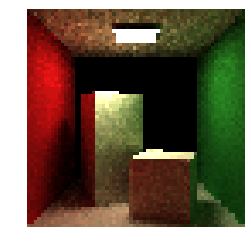

In [35]:
# %%time
NUM_SAMPLES=100
rng_key = random.split(RNG_KEY, eye.shape[0])
img = vec_render_multisample(rng_key, eye, rd, NUM_SAMPLES)
plot = plt.imshow(img,interpolation='none',vmin = 0, vmax = 1)
plt.grid('off')
plt.axis('off')
plt.show()

In [ ]:
plot.get_figure().savefig('cornell_box_ortho.png', bbox_inches='tight', pad_inches=0.)

In [ ]:
%download_file cornell_box_ortho.png

In [ ]:
# plot = plt.imshow((img > 1).astype(np.float32),interpolation='none',vmin = 0, vmax = 1)

# Visualizing Normals

In [ ]:
@jit
def calcNormal(p):
  return normalize(grad(dist)(p))

# @jit
# def calcNormal(p):
#   # derivative approximation via midpoint rule
#   eps = 0.001
#   dx=np.array([eps,0,0])
#   dy=np.array([0,eps,0])
#   dz=np.array([0,0,eps])
#   # exactract just the distance component
#   nor = np.array([
#     sdScene(p+dx)[1] - sdScene(p-dx)[1],
#     sdScene(p+dy)[1] - sdScene(p-dy)[1],
#     sdScene(p+dz)[1] - sdScene(p-dz)[1],
#   ])
#   return normalize(nor)

def trace(rng_key,ro,rd,depth):
  res = raymarch(ro,rd)
  t = res[1]
  p = ro + (t-0.0001)*rd # the 0.001 is needed for stable normals.
  nor = calcNormal(p)
  return nor

trace = jit(trace, static_argnums=(3,))
render_fn = lambda rng_key, ro, rd : trace(rng_key, ro, rd, 0)
vec_render_fn = vmap(render_fn) # will be very slow if we attempt to jit this.

img = vec_render_fn(rng_key, eye, rd)

img = np.fliplr(np.flipud(img.reshape((N,N,3))))
plot = plt.imshow(img,interpolation='none')#,vmin = 0, vmax = 1)
plt.grid('off')
plt.axis('off')

In [ ]:

img = vec_render_fn(rng_key, eye, rd)

img = np.fliplr(np.flipud(img.reshape((N,N,3))))
plot = plt.imshow(img,interpolation='none',vmin = 0, vmax = 1)
plt.grid('off')
plt.axis('off')

plt.imshow((img < 0).astype(np.float32))

In [ ]:
img.min()

# Bonus: lax.scan stack implementation

Implementing path tracing as a for loop is a bit tricker than the typical C++ path tracer implementation, which is to use recursion. This implementation divides 'trace' into two `lax.scan` calls. 

The first scan call computes the new `ro, rd` for the next loop (e.g. the intersection and reflected eye ray), and the outputs are the emission and direct light contributions to radiance arriving at the intersected point `ro`. We also return BRDF and whether the `rd` rays intersected anything.

After we finish the final intersection (`depth == 2`), we proceed backwards from the tail case and accumulate the indirect light contributions to the eye point. Here, we use the BRDF and intersection terms to attenuate the incoming light and compute outgoing light.

If you think about this a little bit, this is essentially what a recursive implementation does, except instead of letting the interpreter push recursive `trace()` calls onto a stack (storing each bounce's emission and direct light contributions in the stack frame memory for use when we unwind out of recursion), we simply do this ourselves manually.

This ended up crashing my computer because it consumed all available RAM. But I'm leaving this code snippet here because I found it a worthwhile exercise to think about.

In [ ]:
# faster-to-jit version implemented with lax.scan
# depth is static.
# from functools import partial

def scatter_eye_rays(carry, depth):
  # Scatters eye-to-scene rays elsewhere into the scene, and carries these 
  # to next iteration. Output contains:
  #   - emission + direct light contributions to the intersected point
  #   - BRDF of intersected point
  #   - did_intersect
  rng_key, ro, rd = carry

  res = raymarch(ro,rd)
  
  # assign lambertian brdfs to intersections
  condlist, choicelist = [], []
  for obj_idx, obj_color in BRDF_MAP:
    condlist.append(res[0] == obj_idx)
    choicelist.append(obj_color)
  brdf = np.select(condlist, choicelist)
  radiance = np.zeros(3)
  # emitted radiance. This is only counted if it's an eye ray, since
  # this contribution is also added in at every bounce.
  # if depth==0: # is eye ray
  is_light = res[0] == OBJ_LIGHT
  is_eye_ray = np.maximum(0, 1.-depth) # hack to avoid 'Abstract value passed to `bool` error'
  Li_e = relu(dot(-rd, nor_light)) * emittedRadiance
  radiance = np.where(is_light, Li_e, radiance) * is_eye_ray
  # end emitted radiance

  t = res[1]
  p = ro + t*rd
  nor = calcNormal(p)
  did_intersect = res[0] != OBJ_NONE
  rng_key, subkey = random.split(rng_key)

  # Estimate direct area contribution
  # each of the intersect points has some amount of light arriving
  # sample point on area light
  rng_key, subkey = random.split(rng_key)
  p_light_x = random.uniform(subkey, minval=-.25, maxval=.25)
  rng_key, subkey = random.split(rng_key)
  p_light_z = random.uniform(subkey, minval=2. + -.25, maxval=2. + .25)
  p_light = np.array([p_light_x, 3.9, p_light_z])
  
  wi_light = normalize(p_light - p)
  res2 = raymarch(p + 0.001 * nor, wi_light)
  # occlusion factor
  vis = res2[0] == OBJ_LIGHT
  Li_direct = (brdf * 
               relu(dot(nor, wi_light)) * 
               relu(dot(nor_light,-wi_light)) * 
               emittedRadiance)
  
  isect_and_vis = np.logical_and(did_intersect, vis)
  zeros = np.zeros_like(radiance)
  radiance += np.where(isect_and_vis, Li_direct, zeros)
  
  ro2 = p + 0.001 * nor # bump along normal.
  rng_key, subkey = random.split(rng_key)
  rd2 = sampleCosineWeightedHemisphere(subkey, nor)

  carry = (rng_key, ro, rd)
  outputs = (did_intersect, radiance, brdf)
  return carry, outputs
  # rng_key, subkey = random.split(rng_key)

In the accumulation step, we accumulate the outgoing radiance for each point by adding the indirect light contribution, starting at $p_3$ (defined to be zero), $p_2$, .. $p_0$.

In [ ]:
def accumulate_outgoing(Li_indirect, x):
  (did_intersect, radiance, brdf) = x
  zeros = np.zeros(3)
  carry = radiance + np.where(did_intersect, brdf * Li_indirect, zeros)
  return carry, zeros

In [ ]:
def trace(rng_key,ro,rd,depth):
  depths = np.array([0, 1, 2])
  initial_value =  (rng_key, ro, rd)
  carry, outputs = lax.scan(scatter_eye_rays, initial_value, depths)
  # accumulate
  initial_value = np.zeros(3) # incoming indirect radiance to the final intersection point is 0. (depth termination)
  xs = tuple(np.flip(o,axis=0) for o in outputs)
  radiance, _ = lax.scan(accumulate_outgoing, initial_value, xs)
  return radiance